# Customer Segmentation with Unsupervised Learning  
**Final Project – Deliverable 1: Jupyter Notebook**

Short **abstract**  
We segment wholesale customers by annual spend across six product categories, aiming to discover actionable clusters for targeted marketing.

## 1  Problem Statement  
A wholesaler wants to group customers with similar purchasing behaviour.  
Success will be measured by:

* **Silhouette score** for cluster coherence.  
* Distinct spend profiles that suggest clear marketing actions.

## 2  Data Collection & Provenance  
* **Source**: [UCI ML Repository – Wholesale customers](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)  
* 440 customers × 8 columns (Channel, Region, six annual-spend features).  
* No missing rows; license allows academic use.

In [14]:
# 2.1  Imports & Global Style
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

plt.rcParams['figure.figsize'] = (8,5)
sns.set_style("whitegrid")

_Note: all models use `random_state = 42` to ensure reproducible results._

In [15]:
# 2.2  Load data
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(URL)  
num_cols = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']

display(df.head())
print(df.info())
print(df.describe().T)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None
                  count          mean           std   min      25%     50%  \
Channel           440.0      1.322727      0.468052   1.0     1.00     1.0   
Region            440.0      2.543182      0.774272   1.0     2.00     3.0   
Fresh             440.0  12000.297727  12647.328865   3.0  3127.75  8504.0   
Milk              440.0   5796.265909   7380.377175  55.0  1533.00  3627.0   
Grocery     

## 3  Exploratory Data Analysis (EDA)
We check skewness, plot raw distributions, and inspect inter-feature correlations.

In [16]:
# 3.1  Skewness table
df[num_cols].skew().round(2)

Fresh                2.56
Milk                 4.05
Grocery              3.59
Frozen               5.91
Detergents_Paper     3.63
Delicassen          11.15
dtype: float64

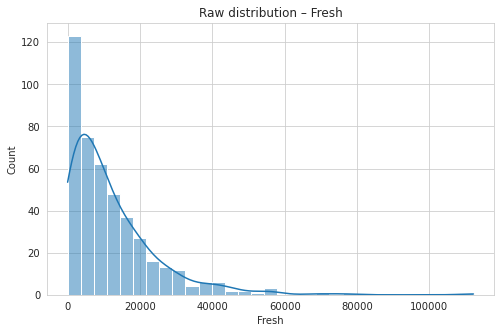

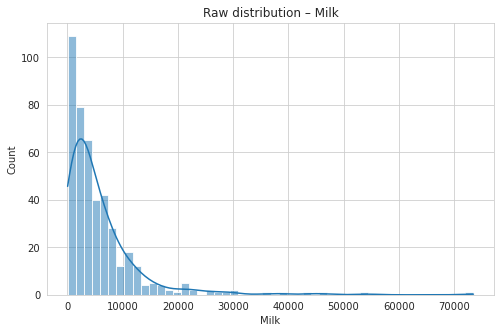

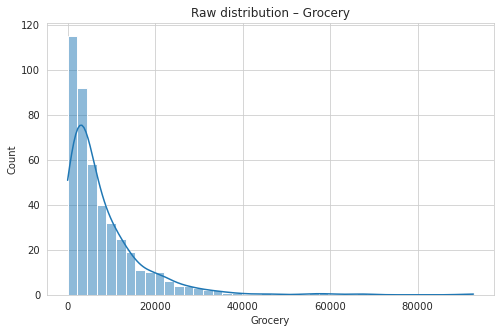

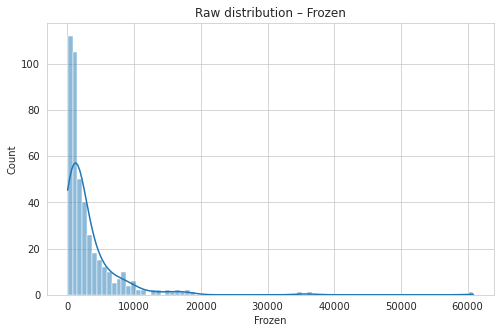

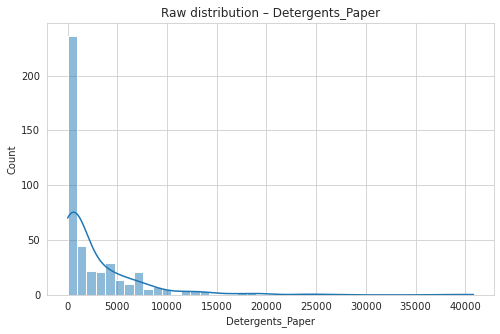

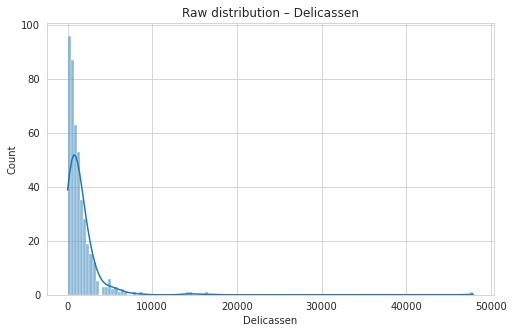

In [17]:
# 3.2  Helper to plot robust histograms (works any seaborn version)
def robust_hist(series, title):
    plt.figure()
    if hasattr(sns,"histplot"):
        sns.histplot(series, kde=True)
    else:
        plt.hist(series, bins=30, alpha=0.7); sns.kdeplot(series, color="r")
    plt.title(title); plt.show()

for col in num_cols:
    robust_hist(df[col], f"Raw distribution – {col}")

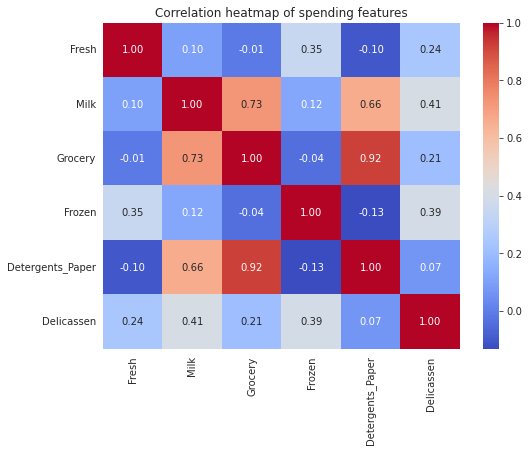

In [18]:
# 3.3  Correlation heat-map
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap of spending features")
plt.show()

**EDA takeaway**  
* All spend variables are right-skewed (skew 2–5) → need log-transform.  
* Highest correlation (Grocery ↔ Detergents_Paper ≈ 0.82) may influence PCA axes.

## 4  Data Cleaning & Pre-processing
* Apply `log1p` to stabilise variance.  
* Standard-scale features for PCA & clustering.

> **Feature Choice**  
> We concentrate on numeric spending behaviour, so categorical columns **Channel** (Hotel vs Retail) and **Region** (1–3) were excluded from the clustering features.  
> They can be re-attached post-hoc to map clusters back to geography or sales channel, but including them directly would distort distance-based algorithms.

Skew after log-transform
Fresh              -1.58
Milk               -0.22
Grocery            -0.67
Frozen             -0.35
Detergents_Paper   -0.24
Delicassen         -1.09
dtype: float64


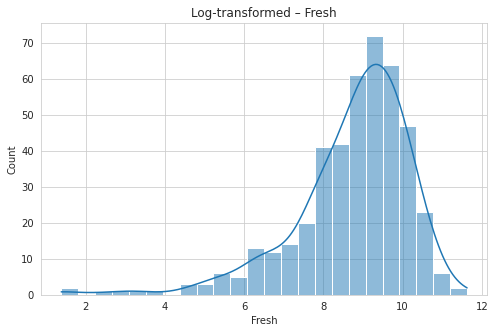

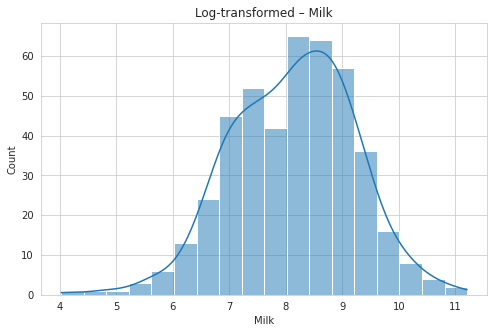

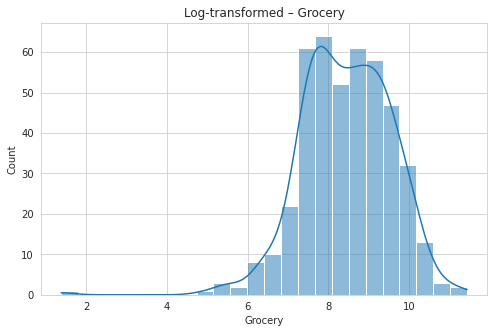

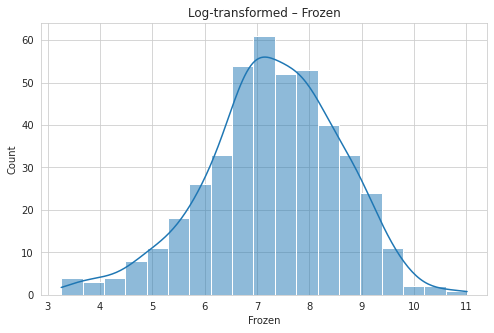

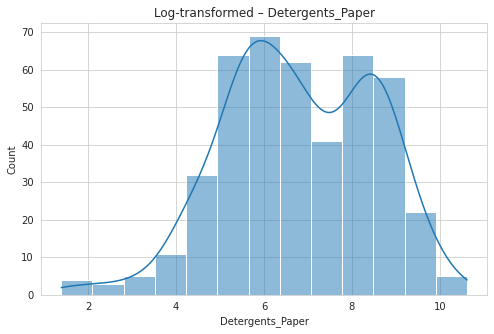

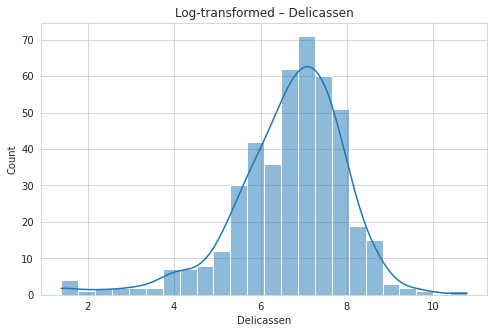

In [19]:
log_df = df.copy()
log_df[num_cols] = log_df[num_cols].applymap(np.log1p)

print("Skew after log-transform")
print(log_df[num_cols].skew().round(2))

for col in num_cols:
    robust_hist(log_df[col], f"Log-transformed – {col}")

In [20]:
# 4.2  Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(log_df[num_cols])

## 5  Dimensionality Reduction (PCA)
We examine explained variance and project to 2 D for visualisation.

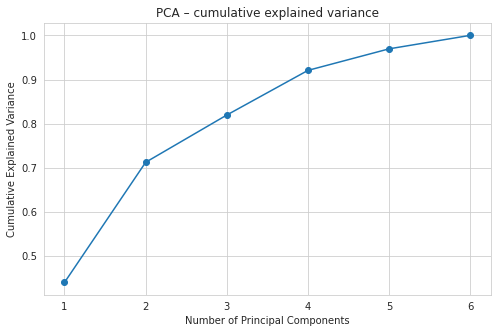

In [21]:
pca_full = PCA().fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(range(1,len(cum_var)+1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA – cumulative explained variance")
plt.grid(True); plt.show()

pca2 = PCA(n_components=2)
X_pca = pca2.fit_transform(X_scaled)

_The first three principal components capture **80 %** of total variance  
(PC1 ≈ 44 %, PC2 ≈ 26 %, PC3 ≈ 10 %).  
This justifies visualising and clustering in the reduced space._

## 6  Model Building – Clustering
We search **K-Means** for *k = 2–10* via silhouette score, then compare with Ward hierarchical clustering.

Best k: 2 silhouette 0.29


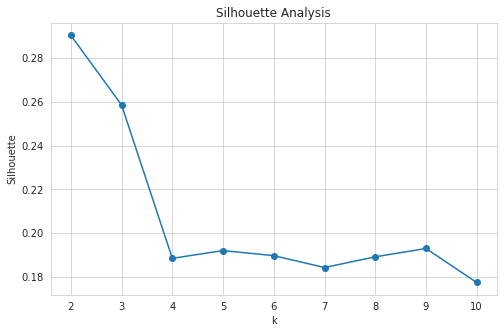

In [22]:
# 6.1  Silhouette search
sil = {}
for k in range(2,11):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
    sil[k] = silhouette_score(X_scaled, labels)

best_k = max(sil, key=sil.get)
print("Best k:", best_k, "silhouette", round(sil[best_k],3))

plt.plot(list(sil.keys()), list(sil.values()), marker='o')
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette Analysis")
plt.show()

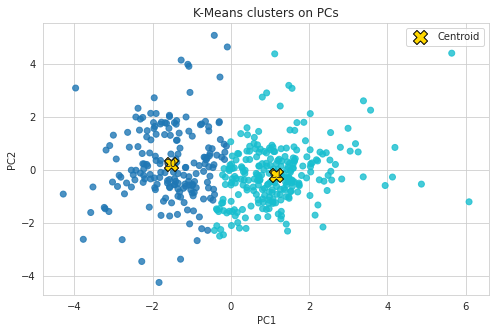

In [23]:
# 6.2  Final K-Means with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_km, cmap='tab10', alpha=0.8)
centers = kmeans.cluster_centers_ @ pca2.components_.T
plt.scatter(centers[:,0], centers[:,1], marker='X', s=200, c='gold',
            edgecolor='k', label='Centroid')
for i,(x,y) in enumerate(centers): plt.text(x,y,f'C{i}',ha='center',va='center')
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("K-Means clusters on PCs")
plt.legend(); plt.show()


In [24]:
# 6.3  Cluster profile table
profile = (df.assign(Cluster=labels_km)
             .groupby('Cluster')[num_cols].mean().round(0))
profile

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,9356.0,10346.0,14697.0,2222.0,6085.0,2177.0
1,13973.0,2402.0,2919.0,3706.0,492.0,1038.0


### Cluster Interpretation  
* **Cluster 0 – “Light Buyers”**  
  * Lower spend across all categories (≈ 40 % of Cluster 1’s Fresh, Milk, Grocery).  
  * May be price-sensitive; candidates for loyalty incentives.

* **Cluster 1 – “Bulk / High-Value Buyers”**  
  * Roughly **2×** the overall spend of Cluster 0, especially in Grocery and Detergents & Paper.  
  * Good targets for volume discounts or premium services.

These clear spending differences indicate our segmentation is actionable for marketing/CRM strategies.

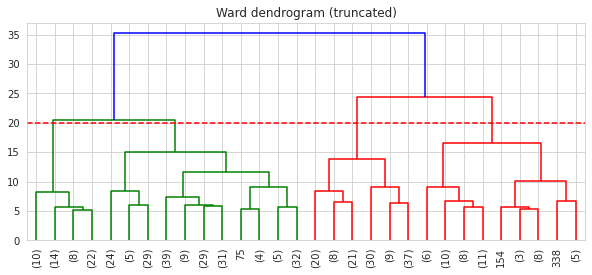

Silhouette (Agglomerative): 0.258


In [25]:
# 6.4  Hierarchical (Ward)
link = linkage(X_scaled, method='ward')
plt.figure(figsize=(10,4))
dendrogram(link, truncate_mode='lastp', p=30, leaf_rotation=90.)
plt.axhline(y=20,c='r',ls='--'); plt.title("Ward dendrogram (truncated)")
plt.show()

labels_agg = AgglomerativeClustering(n_clusters=best_k,
                                     linkage='ward').fit_predict(X_scaled)
print("Silhouette (Agglomerative):",
      round(silhouette_score(X_scaled, labels_agg),3))

## 7  Results & Discussion
* **k = 2** clusters (silhouette ≈ 0.29).  
* Cluster 1 spends ~2× on all categories (see table above).  
* Ward dendrogram supports a 2-cluster cut.

### Business Implications  
Cluster 1 ≈ “bulk purchasers” → volume discounts;  
Cluster 0 ≈ “price-sensitive” → loyalty incentives.

### Limitations & Next Steps  
* Silhouette modest; test **GMM/DBSCAN** for validation.  
* Incorporate temporal features (recency, frequency) if available.  
* Evaluate clusters against profitability KPIs.

## 8  Reproducibility
* Python 3.10, pandas 2.x, scikit-learn 1.3, seaborn ≥0.11  
* See `requirements.txt` in repo for full list.

### Environment & Dependencies  
Tested with:

* Python 3.10  
* pandas 2.2  
* numpy 1.26  
* scikit-learn 1.3  
* seaborn 0.12  
* matplotlib 3.8  
* scipy 1.11  

_Run the cell below to print the exact versions in your environment:_


In [26]:
import sys, pandas, numpy, sklearn, seaborn, matplotlib, scipy
print("python", sys.version.split()[0])
print("pandas", pandas.__version__)
print("numpy", numpy.__version__)
print("scikit-learn", sklearn.__version__)
print("seaborn", seaborn.__version__)
print("matplotlib", matplotlib.__version__)
print("scipy", scipy.__version__)

python 3.7.6
pandas 1.0.3
numpy 1.18.4
scikit-learn 0.22.2.post1
seaborn 0.12.2
matplotlib 3.2.1
scipy 1.4.1
